# Chatting users

Chatting users are defined as users which use many of the tweets to chat with other users. These chatting tweets can be identified by their contents, for example pronouns like *I* and *you* and specific verb forms like *am*.

In [114]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import re
from IPython.display import clear_output

In [3]:
DATADIR = "../data/text/"
QUERY_USERS = r'\b(ik|mij|me|jij|je|jou|jouw|jullie|heb|ben)\b'

In [4]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## 1. Select users

In [152]:
YEAR= "2019"

In [154]:
files = sorted(os.listdir(DATADIR))
pattern = f"^{YEAR}"
totals = {}
matches = {}
for file_name in files:
    if re.search(pattern, file_name):
        squeal(file_name)
        df = pd.read_csv(DATADIR+file_name, index_col="id_str")
        user_counts = df["user"].value_counts()
        for user in user_counts.keys():
            if user in totals:
                totals[user] += user_counts[user]
            else:
                totals[user] = user_counts[user]
        matching_rows = df["text"].str.contains(QUERY_USERS, flags=re.IGNORECASE)
        matching_counts = df[matching_rows]["user"].value_counts()
        for user in matching_counts.keys():
            if user in matches:
                matches[user] += matching_counts[user]
            else:
                matches[user] = matching_counts[user]        

20191231-23.out.gz


In [155]:
chatting_users = {} 
for user in matches:
    if matches[user] >= 0.5 * totals[user] and matches[user] > 10:
        chatting_users[user] = True

In [156]:
len(chatting_users)

144502

In [157]:
pd.DataFrame(chatting_users.keys()).to_csv(f"csv/chatting_users_{YEAR}.csv", index=None)

## 2. Count tweets

In [96]:
def process(df_merged, date, hours_matched):
    matching_rows_topic = df_merged["text"].str.contains(QUERY_TOPIC, flags=re.IGNORECASE)
    matching_rows_i = df_merged["text"].str.contains(QUERY_I, flags=re.IGNORECASE)
    matches = len(df_merged[matching_rows_topic & matching_rows_i])
    misses = len(df_merged[(matching_rows_topic == False) | (matching_rows_i == False)])
    hours_matched[date] = (matches, misses)
    
date = "20200301-00"
hours_matched = {}
df_merged = pd.DataFrame([{"user":"test", "text": "ik"}, {"user":"test", "text": "blij"}])
process(df_merged, date, hours_matched)
assert hours_matched[date] == (0, 2)
hours_matched = {}
df_merged = pd.DataFrame([{"user":"test", "text": "ik blij"}, {"user":"test", "text": ""}])
process(df_merged, date, hours_matched)
assert hours_matched[date] == (1, 1)

In [279]:
YEAR = "2020"
pattern = f"^{YEAR}"
chatting_users = { user: True for user in list(pd.read_csv(f"csv/chatting_users_{YEAR}.csv", index_col=None).iloc[:,0])}

In [280]:
TOPIC = "stress"
QUERY_TOPIC = r'\b(blij)\b'
#TOPIC = "eenzaam"
#QUERY_TOPIC = r'\b(eenzaam)'
#TOPIC = "stress"
#QUERY_TOPIC = r'moe\b|depress|depri|bang|angst|paniek|stress'
QUERY_I = r'\b(ik|mij|me)\b'

In [281]:
hours_matched = {}
for file_name in files:
    if re.search(pattern, file_name):
        squeal(file_name)
        date = re.sub(".out.gz", "", file_name)
        df = pd.read_csv(DATADIR+file_name, index_col="id_str")
        df_merged = pd.merge(df, pd.DataFrame(chatting_users.keys(), columns=["user"]), on=["user"])
        process(df_merged, date, hours_matched)

20201231-23.out.gz


In [282]:
pd.DataFrame([ [hour] + list(hours_matched[hour]) for hour in hours_matched ], columns=["hour", "matched", "missed"]).to_csv(f"csv/hours_matched_{YEAR}_{TOPIC}.csv", index=None)

## 3. Make graph

In [258]:
def moving_median(number_list, size):
    new_list = []
    start_offset = int(size/2)
    for i in range(0, len(number_list)):
        start = max(0, i-start_offset)
        end = min(len(number_list), i+start_offset+1)
        new_list.append(np.median(number_list[start:end]))
    return new_list

In [259]:
def make_date_data_counts(hours_matched):
    date_data_freqs = {}
    date_data_counts = {}
    for hour in hours_matched:
        date = re.sub("-[0-9][0-9]$", "", hour)
        if date not in date_data_freqs:
             date_data_freqs[date] = [0, 0]
        date_data_freqs[date][0] += int(hours_matched[hour][0])
        date_data_freqs[date][1] += int(hours_matched[hour][1])
        if date_data_freqs[date][0] + date_data_freqs[date][1] > 0:
            date_data_counts[date] = date_data_freqs[date][0] / ( date_data_freqs[date][0] + date_data_freqs[date][1] )
    return date_data_counts

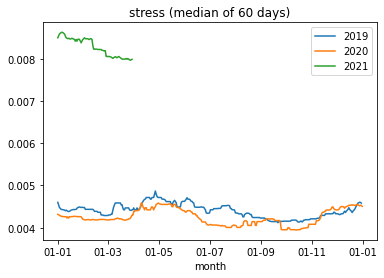

In [283]:
WINDOW_SIZE = 60


def make_plot_data(date_data_counts):
    x = [datetime.datetime.strptime(date, f"%Y%m%d") for date in date_data_counts]
    y = moving_median(list(date_data_counts.values()), WINDOW_SIZE)
    return x, y


def make_x_y(year, topic):
    hours_matched_list = pd.read_csv(f"csv/hours_matched_{year}_{topic}.csv", index_col=None).to_dict(orient="records")
    hours_matched = {}
    for row in hours_matched_list:
        hours_matched[row["hour"]] = [row["matched"], row["missed"]]
    date_data_counts = make_date_data_counts(hours_matched)
    x, y = make_plot_data(date_data_counts)
    return x, y


TOPIC = "stress"
x_2019, y_2019 = make_x_y("2019", TOPIC)
x_2020, y_2020 = make_x_y("2020", TOPIC)
x_2021, y_2021 = make_x_y("2021", TOPIC)
x = x_2019 + x_2020 + x_2021
y = y_2019 + y_2020 + y_2021

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
ax.plot_date(x_2020[:365], y_2019, fmt="-", label="2019")
ax.plot_date(x_2020, y_2020, fmt="-", label="2020")
ax.plot_date(x_2020[:90], y_2021, fmt="-", label="2021")
plt.title(f"{TOPIC} (median of {WINDOW_SIZE} days)")
plt.xlabel("month")
plt.ylabel("")
plt.legend()
plt.savefig(f"{YEAR}-{TOPIC}.png")
plt.show()

In [265]:
len(x_2019), len(x_2020), len(x_2021), len(y_2019), len(y_2020), len(y_2021), len(x), len(y)

(365, 366, 90, 365, 366, 90, 821, 820)